# Exploration CodeGeo <-> Coordonnées GPS

### Sources
GeoCodes Insee <-> Lat/Lon
- insee-coordonnees-communes-departement-region.csv
- https://www.data.gouv.fr/fr/datasets/communes-de-france-base-des-codes-postaux/#/resources
Population
- insee-estimation-population-2024.csv
- https://www.data.gouv.fr/fr/datasets/estimations-de-population/



In [43]:
import pandas as pd
from matplotlib import pyplot as plt 
import numpy as np

In [44]:
df = pd.read_csv('../csv/insee-coordonnees-communes-departement-region.csv')
df = df.rename(columns={"code_commune_INSEE":"codgeo"})
df = df.drop_duplicates(subset=['codgeo'], keep='first')

In [45]:
df.describe()

,code_postal,latitude,longitude,code_commune,code_region
count,36013.000000,35921.000000,35921.000000,36010.000000,35923.000000
mean,46552.135062,46.799357,2.679993,251.443738,52.230827
std,25696.193944,3.550823,4.376192,182.687437,24.324872
min,1000.000000,-21.340107,-61.779579,1.000000,1.000000
25%,24700.000000,45.104444,0.720396,104.000000,28.000000
50%,48500.000000,47.359085,2.673370,217.000000,44.000000
75%,67240.000000,48.826409,4.897983,362.000000,76.000000
max,98882.000000,51.073044,55.754522,909.000000,94.000000


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36013 entries, 0 to 39200
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   codgeo                36013 non-null  object 
 1   nom_commune_postal    36013 non-null  object 
 2   code_postal           36013 non-null  int64  
 3   libelle_acheminement  36013 non-null  object 
 4   ligne_5               235 non-null    object 
 5   latitude              35921 non-null  float64
 6   longitude             35921 non-null  float64
 7   code_commune          36010 non-null  float64
 8   article               2320 non-null   object 
 9   nom_commune           36013 non-null  object 
 10  nom_commune_complet   36013 non-null  object 
 11  code_departement      36010 non-null  object 
 12  nom_departement       35923 non-null  object 
 13  code_region           35923 non-null  float64
 14  nom_region            35923 non-null  object 
dtypes: float64(4), int64(1),

Let' use arbitrary min/max values to select continental France only 

In [47]:
# used GMaps to identify these coordinates
min_lat = 42
max_lat = 52
min_lon = -5
max_lon = 8

df_hex = df[df.latitude.between(min_lat, max_lat) & df.longitude.between(min_lon, max_lon)]

Let' s draw a map to get a sense of what we have left

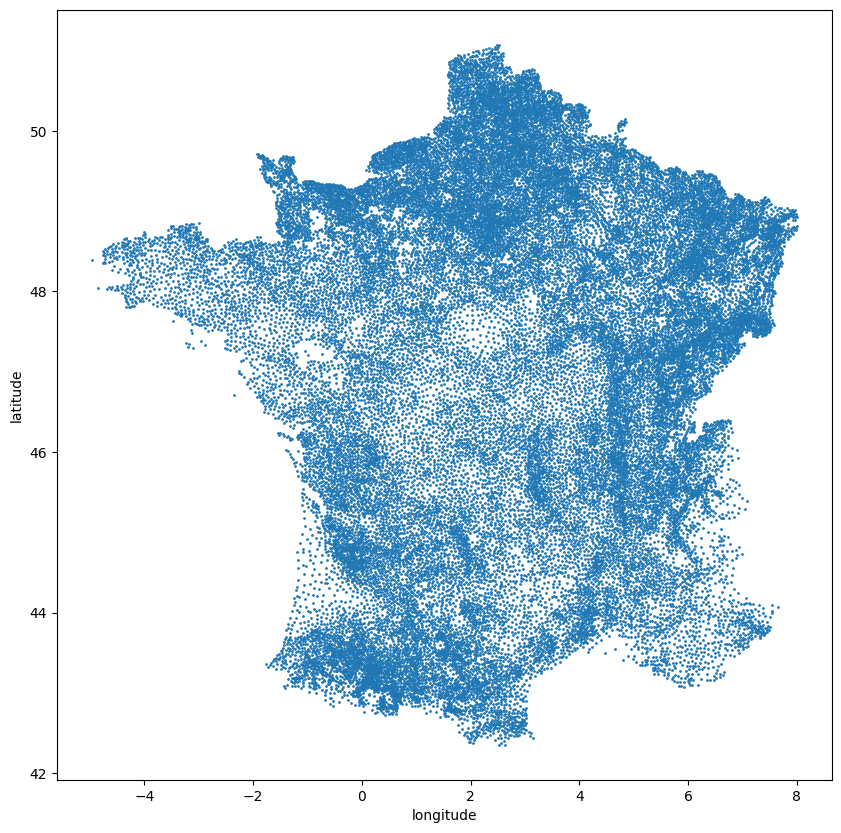

In [48]:
df_hex.plot(x="longitude", y="latitude",  kind="scatter", s=1)
plt.gcf().set_size_inches(10, 10)

In [74]:
#Additional cleanup
# Keep only necessary columns
df_hex = df_hex[["codgeo", "longitude", "latitude", "nom_commune"]]
# Adds a '0' before codgeo for departement < 10
df_hex.loc[:,'codgeo'] = np.where(df_hex.codgeo.str.len() == 4, '0' + df_hex.codgeo, df_hex.codgeo)

Let's work on the Estimated Population CSV now

In [63]:
pop = pd.read_csv('../csv/insee-estimation-population-2024.csv')

In [64]:
pop.head()

,objectid,reg,dep,cv,codgeo,libgeo,p13_pop,p14_pop,p15_pop,p16_pop,p17_pop,p18_pop,p19_pop,p20_pop,p21_pop
0,115658,52,85,8502,85062,Châteauneuf,968.0,993.0,1013.0,1027.0,1056,1085.0,1114.0,1118.0,1134.0
1,115659,26,58,5808,58300,Urzy,1839.0,1835.0,1828.0,1802.0,1775,1749.0,1746.0,1747.0,1742.0
2,115660,43,70,7012,70137,Chassey-lès-Montbozon,218.0,217.0,216.0,215.0,217,215.0,215.0,220.0,225.0
3,115661,21,51,5123,51649,Vitry-le-François,13174.0,13144.0,12805.0,12552.0,12133,11743.0,11376.0,11458.0,11454.0
4,115662,11,78,7811,78638,Vaux-sur-Seine,4749.0,4715.0,4788.0,4857.0,4927,4929.0,5010.0,5020.0,5083.0


In [65]:
pop = pop[["codgeo", "libgeo", "p21_pop", 'p20_pop']]

Let's join the Commune with Coordinates and the Estimation Population datasets

In [66]:
loc_with_pop = df_hex.join(pop.set_index('codgeo'), on='codgeo', how='left')

In [67]:
loc_with_pop.describe()

,longitude,latitude,p21_pop,p20_pop
count,35401.000000,35401.000000,34463.000000,34472.000000
mean,2.707373,47.003272,1889.499550,1882.219395
std,2.580491,2.179394,8644.384593,8605.796179
min,-4.960406,42.355978,0.000000,0.000000
25%,0.708993,45.206862,199.000000,199.000000
50%,2.635579,47.405866,459.000000,459.000000
75%,4.823961,48.840215,1161.000000,1159.000000
max,7.998342,51.073044,504078.000000,498003.000000


/home/jacques/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jacques/.local/lib/python3.10/site-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


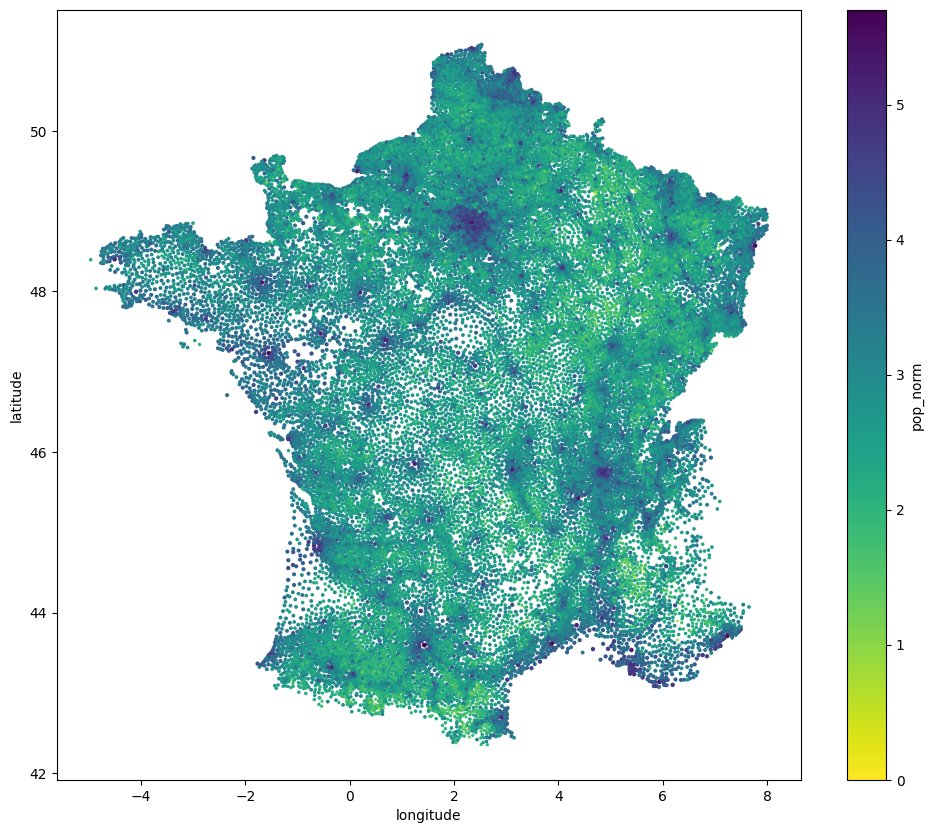

In [73]:
loc_with_pop['pop_norm'] = np.log10(loc_with_pop.p21_pop)
loc_with_pop.plot(x="longitude", y="latitude",  kind="scatter", c='pop_norm', s='pop_norm', cmap='viridis_r')
plt.gcf().set_size_inches(12, 10)

Let's check the locations with missing population data

In [70]:
loc_without_pop = loc_with_pop[loc_with_pop.p21_pop.isna() & loc_with_pop.p20_pop.isna()]

In [71]:
loc_without_pop

,codgeo,longitude,latitude,nom_commune,libgeo,p21_pop,p20_pop
61,01059,5.737189,45.950008,Brénaz,NaN,NaN,NaN
96,01091,5.770176,46.129334,Châtillon-en-Michaille,NaN,NaN,NaN
104,01097,5.724998,45.882405,Chavornay,NaN,NaN,NaN
128,01122,5.608608,45.944277,Cormaranche-en-Bugey,NaN,NaN,NaN
147,01144,4.998639,46.336278,Dommartin,NaN,NaN,NaN
...,...,...,...,...,...,...,...
38084,89484,3.309975,47.916742,Volgré,NaN,NaN,NaN
38158,90073,6.885458,47.585619,Moval,NaN,NaN,NaN
38247,91182,2.412880,48.621635,Courcouronnes,NaN,NaN,NaN
38260,91222,2.132611,48.306978,Estouches,NaN,NaN,NaN


So we have 928 values with missing pop data (2020 or 2021)